<h1 style="text-align:center; padding:2%"> Recommendations with IBM </h1>


<p style="text-align:center; padding-bottom:1%">In this notebook I use the skills learned in the <a href="https://www.udacity.com/course/data-scientist-nanodegree--nd025">Udacity Data Scientist Nanodegree Program</a> to create recommendations based on real data from the IBM Watson Studio platform.</p>

## Table of Contents

I. [Exploratory Data Analysis](#Part-1---Exploratory-Data-Analysis) <br>
II. [Rank Based Recommendations](#Part-2---Rank-Based-Recommendations)<br>
III. [User-User Based Collaborative Filtering](#Part-3---User-User-Based-Collaborative-Filtering)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Part-4---Content-Based-Recommendations)<br>
V. [Matrix Factorization](#Part-5---Matrix-Factorization)<br>
<hr>

# Setup

## Import Libraries

In [1]:
# To handle data
import numpy as np 
import pandas as pd

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# For testing (from Udacity)
import project_tests as t

## Load data

In [2]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data
print(df.shape)
df.head()

(45993, 3)


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
print(df_content.shape)
df_content.head()

(1056, 5)


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


<hr>

# Part 1 - Exploratory Data Analysis

`1. What is the distribution of how many articles a user interacts with in the dataset?`

In [5]:
# count number of articles by user
reads_per_user = df.groupby('email').count()['article_id']

# show descriptive statistics
reads_per_user.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

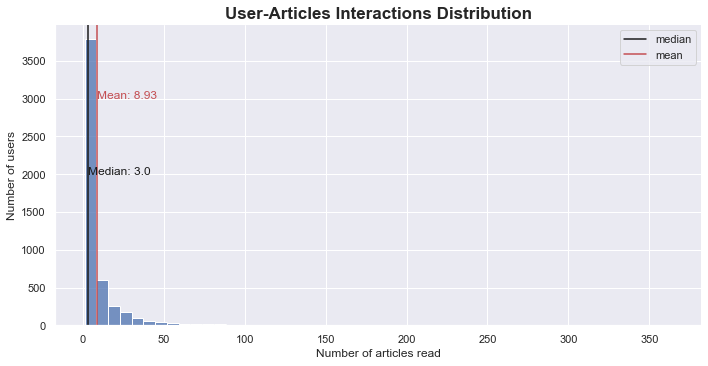

In [6]:
# Central tendencies
median_views = reads_per_user.median()
mean_views = reads_per_user.mean()
max_views_by_user = reads_per_user.max()

# Plot
sns.displot(reads_per_user, aspect=2, bins=50)

plt.axvline(x=median_views, ymin=0, ymax=2500, color='k', label='median')
plt.annotate(xy=(median_views, 2000), text=f'Median: {median_views:.1f}', color='k');

plt.axvline(x=mean_views, ymin=0, ymax=2500, color='r', label='mean')
plt.annotate(xy=(mean_views, 3000), text=f'Mean: {mean_views:.2f}', color='r');

plt.title('User-Articles Interactions Distribution', weight='bold', size=17)
plt.ylabel('Number of users')
plt.xlabel('Number of articles read')
plt.legend()
plt.show()

In [7]:
# Fill in the median and maximum number of user_article interactios below
print(f'50% of individuals interact with {median_views} number of articles or fewer.')
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


<br>

`2. Explore and remove duplicate articles from the df_content dataframe.`

In [8]:
# Check if there are duplicated articles (False if there are duplicates)
df_content.article_id.nunique() == df_content.shape[0]

False

In [9]:
# Find and explore duplicate articles
df_content[df_content.article_id.duplicated(keep=False)].sort_values(by='article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

# Check results (True if there are no duplicates)
df_content.article_id.nunique() == df_content.shape[0]

True

<br>

`3. User-Articles Interactions:`

In [11]:
unique_articles = df.article_id.nunique()
total_articles = df_content.article_id.nunique()
unique_users = df.email.nunique()
user_article_interactions = df.shape[0]

print('a. The number of unique articles that have an interaction with a user:', unique_articles)
print('b. The number of unique articles in the dataset (whether they have any interactions or not):', total_articles)
print('c. The number of unique users in the dataset (excluding null values):', unique_users)
print('d. The number of user-article interactions in the dataset:', user_article_interactions)

a. The number of unique articles that have an interaction with a user: 714
b. The number of unique articles in the dataset (whether they have any interactions or not): 1051
c. The number of unique users in the dataset (excluding null values): 5148
d. The number of user-article interactions in the dataset: 45993


<br>

`4. Most viewed **article_id**, as well as how often it was viewed. `

In [12]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.article_id.value_counts().head(1).index[0])

# The most viewed article in the dataset was viewed how many times?
max_views = df.article_id.value_counts().head(1).values[0]

After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### Test

In [14]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_views,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


<hr>

# Part 2 - Rank-Based Recommendations
We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In cases like these, the popularity of an article can really only be based on how often an article was interacted with.

`1. Write a function to return the 'n' top articles ordered with most interactions as the top.`

In [15]:
def get_top_articles(n, df=df):
    """Returns the *n* top articles 
    Arguments:
        n - (int) number of top articles to return
        df - (pandas dataframe) df with necessary input data
    Returns:
        top_articles - (list) a list with the top 'n' articles titles"""
    
    # Count number of users by article title and select top 'n'
    top_articles = list(df.groupby('title').count()['user_id'].sort_values(ascending=False).index[:n])

    return top_articles

def get_top_articles_ids(n, df=df):
    """Returns the *n* top articles ids
    Arguments:
        n - (int) number of top articles to return
        df - (pandas dataframe) df with necessary input data
    Returns:
        top_articles - (list) a list with the top 'n' articles titles"""
    
    # Count number of users by article article_id and select top 'n'
    top_articles_ids = list(df.groupby('article_id').count()['user_id'].sort_values(ascending=False).index[:n])

    return top_articles_ids

In [16]:
# Checking functions
n = 10
print(f'Top {n} articles:\n', get_top_articles(n))
print(f'\nTop {n} articles ids:\n', get_top_articles_ids(n))

Top 10 articles:
 ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']

Top 10 articles ids:
 [1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### Test

In [17]:
# Test function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


<hr>

# Part 3 - User-User Based Collaborative Filtering

`1. Create a User-Item Matrix`
* Each **user** should only appear in each **row** once.

* Each **article** should only show up in one **column**.  

* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  

* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [18]:
print(df.shape)
df.head()

(45993, 3)


,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
def create_user_item_matrix(df):
    """Create a user item matrix with users as rows and articles as the columns
    and 1 values if a user has interacted with the article and 0 otherwise
    Arguments:
        df - (pandas dataframe) input data containing article_id, title, user_id columns
    Returns:
        user_item - (np.array) user item matrix"""
    
    # Create an extra column to show whether or not an user interacts with an article
    # In this case, all articles in this dataset are expected to have at least one interaction
    df = df.copy()
    df['interactions'] = 1
    
    # Create the user item matrix and fill nan with 0
    user_item = df.groupby(['user_id','article_id'])['interactions'].max().unstack().fillna(0)
    
    return user_item

In [20]:
user_item = create_user_item_matrix(df)

### Test

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


<br>

`2. Find similar users`

Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. 

Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    """Computes the similarity of every pair of users based on their dot product
    Arguments:
        user_id - (int) a user id
        user_item - (pandas dataframe) matrix of users by articles:
                    1's when a user has interacted with an article, 0 otherwise
    Returns:
        similar_users - (list) an ordered list where the closest users are listed first
    """
    # compute similarity between users using dot product
    similarity = user_item.dot(user_item.T)
    
    # Get similar users to the provided user ('user_id')
    similarity_user_id = similarity[user_id]
    
    # sort by similarity & create list of just the ids
    most_similar_users = list(similarity_user_id.sort_values(ascending=False).index)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


<br>

`3. Find articles to recommend using similarity between users` 

In [24]:
def get_article_names(article_ids, df=df):
    """Get article name based on article id
    Arguments:
        article_ids - (list) a list of article ids in string format ('1024.0')
        df - (pandas dataframe) df containing information about articles and users
    Returns:
        articles_names - (list) a list of article titles associated with the list of article ids"""
    
    # Cast article ids to floats to match dtype in dataframe
    articles_ids = [float(id_) for id_ in article_ids]
    # Create a set list with article names
    articles_names = list(set(df[df.article_id.isin(articles_ids)].title))
    
    return articles_names

In [25]:
def get_user_articles(user_id, user_item=user_item):
    """Provide a list of the article ids and article titles seen by a given user
    Arguments:
        user_id - (int) user id
        user_item - (pandas dataframe) matrix of user-articles interactions
    Returns:
        articles_ids - (list) list of article ids seen by the user in str format
        articles_names - (list) list of article titles seen by the user
    """
    
    # Find articles read by the user & cast to str
    articles = user_item[(user_item.index == user_id)].iloc[0]
    articles_ids = list(articles[articles.isin([1])].index)
    articles_ids = [str(id_) for id_ in articles_ids]
    
    # Find articles' name
    articles_names = get_article_names(articles_ids)
    
    return articles_ids, articles_names

In [26]:
def user_user_recs(user_id, m=10):
    """Recommends 'm' articles to 'user_id' that they have not seen,
    based on the similiary with other users and the articles they have read
    Arguments:
        user_id - (int) user id
        m - (int) number of recommendations for the user
    Returns:
        recs - (list) list of recommendations for the user"""
    
    # find similar users
    similar_users = find_similar_users(user_id)
    
    # find articles user has already seen
    user_articles_id, user_articles_name = get_user_articles(user_id)
    
    # find article similar users have read (but user_id has not) up to 'm' articles
    recs = []
    for user in similar_users:
        for article in get_user_articles(user)[1]:
            if len(recs) < m:
                if not article in user_articles_name:
                    recs.append(article)      

    return recs # return your recommendations for this user_id   

In [27]:
# Check Results
user_user_recs(1, 10) # Return 10 recommendations for user 1

['deploy your python model as a restful api',
 'using github for project control in dsx',
 'programmatic evaluation using watson conversation',
 'car performance data',
 'deep learning with data science experience',
 'awesome deep learning papers',
 'visualize data with the matplotlib library',
 'data science platforms are on the rise and ibm is leading the way',
 'learn basics about notebooks and apache spark',
 'from spark ml model to online scoring with scala']

<br>

### Test

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


<br>

`4. Improve consistency of user_user_recs`
* Instead of arbitarily choosing when we obtain users who are all the same closeness to a given user, choose the users that have the most total article interactions before choosing those with fewer article interactions
* Instead of arbitrarly choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the most total interactions before choosing those with fewer total interactions. This ranking can be obtained with the **top_articles** function wrote earlier.

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    """It find similar users, sorted by similarity and number of interactions 
    (num. articles viewed by user, if any)
    Arguments:
        user_id - (int) user id
        df - (pandas dataframe) data containing user-article interactions
        user_item - (pandas dataframe) matrix of users by articles 
                                        (1's = interaction | 0 otherwise)
    Returns:
        neighbors_df - (pandas dataframe) a dataframe with:
                        neighbor_id - user_id of neighbor user
                        similarity - measure of similarity between each user and provided user_id
                        num_interactions - the number of articles viewed by the user
    """
    
    # Find similar users
    # compute similarity between users using dot product
    similarity = user_item.dot(user_item.T)
    
    # Get similar users to the provided user ('user_id')
    similarity_user_id = similarity[user_id]
    
    # create dataframe with neighbor users, keeping neighbor id & similarity with provided user
    neighbors_df = pd.DataFrame(similarity_user_id)
    neighbors_df = neighbors_df.reset_index()
    neighbors_df = neighbors_df.rename({'user_id':'neighbor_id',
                                          user_id:'similarity'}, axis=1)
    neighbors_df = neighbors_df.drop(neighbors_df[neighbors_df.neighbor_id == user_id].index)
    
    # add num_interactions to dataframe
    num_interactions = []
    for user in neighbors_df.neighbor_id:
        num_interactions.append(len(df[df.user_id == user]))
    neighbors_df['num_interactions'] = num_interactions        
           
    # sort neighbors by num_interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df.reset_index(drop=True)

In [30]:
def user_user_recs(user_id, m=10):
    """Recommends 'm' articles to 'user_id' that they have not seen,
    based on the similiary with other users and the articles they have read
    Arguments:
        user_id - (int) user id
        m - (int) number of recommendations for the user
    Returns:
        recs - (list) list of recommendations for the user"""
    
    # find similar users
    similar_users = find_similar_users(user_id)
    
    # find articles user has already seen
    user_articles_id, user_articles_name = get_user_articles(user_id)
    
    # find article similar users have read (but user_id has not) up to 'm' articles
    recs = []
    for user in similar_users:
        for article in get_user_articles(user)[1]:
            if len(recs) < m:
                if not article in user_articles_name:
                    recs.append(article)      

    return recs # return your recommendations for this user_id   

In [31]:
def user_user_recs_part2(user_id, m=10):
    """Finds up to 'm' recommendations for provided user_id based on similiarity with other users
    Arguments:
        user_id - (int) user id
        m - (int) number of recommendations for the user
    Returns:
        recs_ids - (list) list of recommendations for the user by article id
        recs_names - (list) list of recommendations for the user by article name"""
    
    # Find articles user has already seen
    user_articles_id, user_articles_name = get_user_articles(user_id)
    
    # Find similar users
    neighbors = get_top_sorted_users(user_id)
    
    # Find aricles that neighbors have read (but user_id has not) up to 'm' articles
    recs_ids = []
    for neighbor in neighbors.neighbor_id:
        for new_article_id in get_user_articles(neighbor)[0]:
            if len(recs_ids) < m:
                if not new_article_id in user_articles_id:
                    recs_ids.append(new_article_id)   

    recs_names = get_article_names(recs_ids)
        
    return recs_ids, recs_names

In [32]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['tensorflow quick tips', 'timeseries data analysis of iot events by using jupyter notebook', 'learn tensorflow and deep learning together and now!', 'statistics for hackers', "a beginner's guide to variational methods", 'neural networks for beginners: popular types and applications', 'accelerate your workflow with dsx', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications', 'challenges in deep learning']


<br>

### Test

`5. Test 'get_top_sorted_users' function`

In [33]:
# Gets row with xth most similar user then selects first column (contains neighbor_id)
user1_most_sim = get_top_sorted_users(1).iloc[0, 0]
user131_10th_sim = get_top_sorted_users(131).iloc[9, 0]

In [34]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


<br>

`6. How to make recommendations to a new user?`

* We cannot use user-user based collaborative filtering with a new user, as we do not have enough data (Cold Start Problem)
* In these cases, a good solution is to simply find recommendations using a ranking approach where the most popular articles are recommended
* If the user provides some information, knowledge-based recommendations could be implemented by creating some kind of filter in top of the ranking system

<br>

`7. Provide the Top 10 recommended articles for a new user`

In [35]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
n = 10
new_user_recs = get_top_articles_ids(n)
new_user_recs = [str(id_) for id_ in new_user_recs]

In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


<br><hr>

# Part 4 - Content Based Recommendations 
## (Not Required)
Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. You might consider content to be the doc_body, doc_description, or doc_full_name. There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.

<br><hr>

# Part 5 - Matrix Factorization
In this part of the notebook, I'll use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1. Set-up`

In [37]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [38]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

`2. Use SVD on the user-item matrix`

SVD, or Singular Value Decomposition, splits the user-item matrix into three matrices: $U \Sigma V^T$

* **$U$**: how users are related to latent features -> (n,k) ~ (users, latent features)
* **$\Sigma$**: how much each latent features (lf) matters in predicting user-item interactions -> (k,k) ~ (lf, lf)
* **$V^T$**: how latent features are represented in the items -> (k, m) ~ (lf, items)

With:
* $n$: number of users
* $k$: number of latent features
* $m$: number of items


[NumPy SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)

In [39]:
u, s, vt = np.linalg.svd(user_item_matrix)
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

Here we can use the numpy SVD function as there are no missing values in our user-item matrix.

If we had missing values, we should use the Funk SVD method.

<br>

`3. Testing the impact of latent features` 

How do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

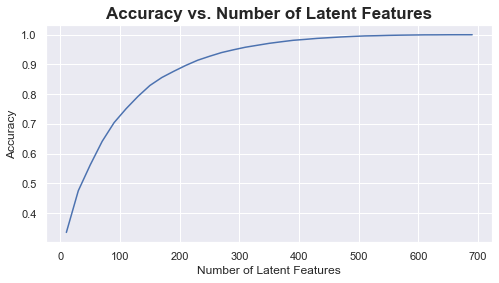

In [40]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.figure(figsize=(8,4))    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features', weight='bold', size=17);

<br>

`4. Splitting the data: training and test sets ` 

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

In [41]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    """
    Arguments:
        df_train - (pandas dataframe) training dataframe
        df_test - (pandas dataframe) test dataframe
    Returns:
        user_item_train - (pandas dataframe) a user-item matrix of the training dataframe
                         (unique users for each row and unique articles for each column)
        user_item_test - (pandas dataframe)  a user-item matrix of the testing dataframe
                        (unique users for each row and unique articles for each column)
        test_idx - (numpy array) all of the test user ids
        test_arts - (numpy array) all of the test article ids
    """
    # Create user_item matrix
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Save user id and article id as np array
    test_idx = df_test.user_id.values
    test_arts = df_test.article_id.values
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [42]:
user_item_train.shape, user_item_test.shape, test_idx.shape, test_arts.shape

((4487, 714), (682, 574), (5993,), (5993,))

In [43]:
# How many users can we make predictions for in the test set?
common_users_idx = np.intersect1d(user_item_train.index, test_idx)
len(common_users_idx)

20

In [44]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
n_new_users = user_item_test.shape[0] - len(common_users_idx)
n_new_users

662

In [45]:
# How many articles can we make predictions for in the test set?
common_arts_idx = np.intersect1d(user_item_train.columns, test_arts)
len(common_arts_idx)

574

In [46]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
n_new_arts = user_item_test.shape[1] - len(common_arts_idx)
n_new_arts

0

Note for the reviewer: Without changing "articles" to "movies" in 'sol_4_dict' it leads to a KeyError...

<!-- I had to take a peak at the test script because I kept having a key error.
The keys that you provide in this sol_4_dict have the word "articles", but in your test script it says "movies"
and that leads to a KeyError: 
`KeyError: 'How many movies can we make predictions for in the test set?'`

I had to change the word here to be able to pass the test
You should modify the test script, as here we are not recommending movies
 -->

<!-- # Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict) -->

In [47]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


<br>

`5. Finding the optimal number of latent features based on the accuracy on the test data` 

In [48]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [49]:
# Find the subset of rows in the user_item_test on which we can predict
sub_user_item_test = user_item_test.loc[common_users_idx]

In [50]:
# the 'u', 's', vt' matrices do not have indices values, thus to know what rows are in common between
# train and test sets, we need to keep "True" / "False" values instead of actual indices values
common_users = user_item_train.index.isin(test_idx)
common_arts = user_item_train.columns.isin(test_arts)

u_test = u_train[common_users, :]
vt_test = vt_train[:, common_arts]

In [51]:
num_latent_feats = np.arange(10,700+10,20)
sum_train_errs = []
sum_test_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product = prediction
    train_user_item_pred = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    test_user_item_pred = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    train_diffs = np.subtract(user_item_train, train_user_item_pred)
    test_diffs = np.subtract(sub_user_item_test, test_user_item_pred)
    
    # total errors and keep track of them
    train_errors = np.sum(np.sum(np.abs(train_diffs)))
    test_errors = np.sum(np.sum(np.abs(test_diffs)))
    
    sum_train_errs.append(train_errors)
    sum_test_errs.append(test_errors)

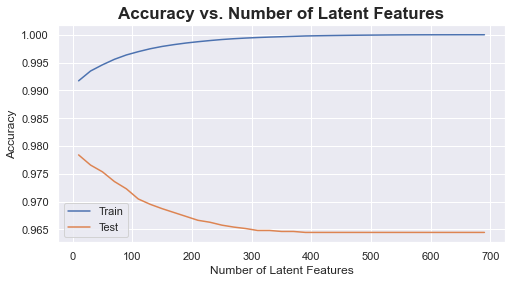

In [52]:
plt.figure(figsize=(8,4))    
plt.plot(num_latent_feats, 1 - np.array(sum_train_errs)/user_item_train.size, label='Train')
plt.plot(num_latent_feats, 1 - np.array(sum_test_errs)/sub_user_item_test.size, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features', weight='bold', size=17)
plt.legend()
plt.show()

<br>

`6. Discuss results` 

What might be done to determine if the recommendations made with any of the above recommendation systems are an improvement to how users currently find articles? 

* We cannot test the impact of our rank-based recommendations nor our user-user based collaborative filtering and, due to the Cold Start Problem, we can only test our recommendations using matrix factorization on a small proportion of users
* To determine if the recommendations are an improvement, we can apply A/B testing and chose metrics to monitor to see if they increase by applying these recommendations. For example, we could measure if users with that have article recommendations spend more time on the platform, or more time reading the articles 